## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|x^2+y^2 < 1\}$

The exact solution to this problem is $$u = \frac{1}{4}(x^2+y^2-1).$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        
        self.linear7 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        output = F.relu(self.linear7(y))
        return output

In [2]:
def draw_graph(mod):
    points = np.arange(-1, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [3]:
def cal_loss(mod):
    points = np.arange(-1, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() + U_groundtruth(re)
            #?????????
            if re[0] ** 2 + re[1] ** 2 < 1 : 
                mmm += abs(z[i, j])
                t = t + 1
    
    return mmm / t

In [4]:
#U_groundtruth = 1/4*(x^2+y^2)-1/4
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    #re = 0
    re = (t[0] ** 2 + t[1] ** 2 - 1).item() / 4
    return re

def on_sample(m):
    theta = np.random.rand() * 2 * pi
    a = np.linspace(0, 2*pi, 100)
    
    re = np.zeros(m)
    re[0] = cos(theta)
    re[1] = sin(theta)
    re = torch.tensor(re, requires_grad=True)
    return re

In [14]:
"""
Train with the grid
"""
gamma = 100
model = DeepRitzNet(m)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
in_error_iter = [] #record the error in Omega every print_every_iter=100 times
on_error_iter = [] #record the error on the border of Omega every print_every_iter=100 times

mm = 1
points = np.arange(-1, 1, 0.1)
xs, ys = np.meshgrid(points, points)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xl, yl = xs.size()
                
lr1 = 0.01
lr2 = 0.005
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr2)
ccc = 1

mod = DeepRitzNet(m)

for k in range(600):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (model(x_input_1) + model(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (model(x_input_2) + model(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    
    grid = np.linspace(0, 2*pi, 200)
    n2 = 1
    for i in range(200):
        if i < 199:
            grid_i_1 = grid[i+1]
        else:
            grid_i_1 = grid[0]
        th = (grid[i] + grid_i_1) / 2
        x1 = np.zeros(m)
        x1[0] = cos(th)
        x1[1] = sin(th)
        x1 = torch.tensor(x1).float()
        yy = model(x1)
        t = floor(abs(yy)*100)
        for theta in np.linspace(grid[i], grid_i_1, t):
            x_input = np.zeros(m)
            x_input[0] = cos(theta)
            x_input[1] = sin(theta)
            x_input = torch.tensor(x_input).float()
            y = model(x_input)
            regularization += y**2 
            n2 = n2 + 1
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    cal_l = cal_loss(model)
    print(k, " loss to real solution: ", cal_l)
    
    if cal_l < ccc:
        mod.load_state_dict(model.state_dict())
        ccc = cal_l
    
    loss += regularization
    
    #and step the optimizer
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss.backward()
    if k < 270:
        optimizer1.step()
    else:
        optimizer2.step()

0  epoch, loss:  -0.2498265653848648
0  epoch, regularization loss:  0.12529179453849792
0  loss to real solution:  0.20198159734
1  epoch, loss:  -0.29166245460510254
1  epoch, regularization loss:  0.14733168482780457
1  loss to real solution:  0.252786461272
2  epoch, loss:  -0.32140523195266724
2  epoch, regularization loss:  0.16623322665691376
2  loss to real solution:  0.290157928149
3  epoch, loss:  -0.3270792067050934
3  epoch, regularization loss:  0.1658439040184021
3  loss to real solution:  0.298304399202
4  epoch, loss:  -0.3182613253593445
4  epoch, regularization loss:  0.1526615023612976
4  loss to real solution:  0.289630305629
5  epoch, loss:  -0.30587828159332275
5  epoch, regularization loss:  0.1379576474428177
5  loss to real solution:  0.277171184775
6  epoch, loss:  -0.2987080514431
6  epoch, regularization loss:  0.12883751094341278
6  loss to real solution:  0.271326263039
7  epoch, loss:  -0.2981269657611847
7  epoch, regularization loss:  0.1261038482189178

62  epoch, loss:  -0.20577670633792877
62  epoch, regularization loss:  0.07992768287658691
62  loss to real solution:  0.20396069928
63  epoch, loss:  -0.21541985869407654
63  epoch, regularization loss:  0.0897747352719307
63  loss to real solution:  0.214910942207
64  epoch, loss:  -0.2148602157831192
64  epoch, regularization loss:  0.09071438759565353
64  loss to real solution:  0.214805457797
65  epoch, loss:  -0.2075636088848114
65  epoch, regularization loss:  0.08477349579334259
65  loss to real solution:  0.206254924269
66  epoch, loss:  -0.19805806875228882
66  epoch, regularization loss:  0.07675272226333618
66  loss to real solution:  0.194404403445
67  epoch, loss:  -0.19132553040981293
67  epoch, regularization loss:  0.07120731472969055
67  loss to real solution:  0.184972347023
68  epoch, loss:  -0.1740700751543045
68  epoch, regularization loss:  0.05689758434891701
68  loss to real solution:  0.161937950265
69  epoch, loss:  -0.1789095252752304
69  epoch, regularizat

123  epoch, loss:  -0.12883062660694122
123  epoch, regularization loss:  0.04277768358588219
123  loss to real solution:  0.0977397096751
124  epoch, loss:  -0.12959003448486328
124  epoch, regularization loss:  0.044135063886642456
124  loss to real solution:  0.096694673225
125  epoch, loss:  -0.13094502687454224
125  epoch, regularization loss:  0.046291060745716095
125  loss to real solution:  0.0969472387558
126  epoch, loss:  -0.13059109449386597
126  epoch, regularization loss:  0.046035654842853546
126  loss to real solution:  0.0951973348339
127  epoch, loss:  -0.12841635942459106
127  epoch, regularization loss:  0.043423980474472046
127  loss to real solution:  0.0911728500611
128  epoch, loss:  -0.12888871133327484
128  epoch, regularization loss:  0.04473566636443138
128  loss to real solution:  0.0910116148014
129  epoch, loss:  -0.1273818165063858
129  epoch, regularization loss:  0.04359240457415581
129  loss to real solution:  0.088374911633
130  epoch, loss:  -0.1248

182  epoch, loss:  -0.09904015809297562
182  epoch, regularization loss:  0.03759646415710449
182  loss to real solution:  0.0394777275608
183  epoch, loss:  -0.0964183509349823
183  epoch, regularization loss:  0.034953538328409195
183  loss to real solution:  0.0357164462069
184  epoch, loss:  -0.08096473664045334
184  epoch, regularization loss:  0.019319768995046616
184  loss to real solution:  0.0202792092746
185  epoch, loss:  -0.07719102501869202
185  epoch, regularization loss:  0.01641935482621193
185  loss to real solution:  0.0173221196067
186  epoch, loss:  -0.08776593953371048
186  epoch, regularization loss:  0.027032464742660522
186  loss to real solution:  0.0255467908137
187  epoch, loss:  -0.0908115804195404
187  epoch, regularization loss:  0.029977500438690186
187  loss to real solution:  0.0297362986542
188  epoch, loss:  -0.08248771727085114
188  epoch, regularization loss:  0.02046443521976471
188  loss to real solution:  0.0219221940627
189  epoch, loss:  -0.081

241  epoch, loss:  -0.08192899823188782
241  epoch, regularization loss:  0.028161104768514633
241  loss to real solution:  0.0346864450361
242  epoch, loss:  -0.06557610630989075
242  epoch, regularization loss:  0.010807430371642113
242  loss to real solution:  0.015816235893
243  epoch, loss:  -0.05918560549616814
243  epoch, regularization loss:  0.006117958575487137
243  loss to real solution:  0.0117522859573
244  epoch, loss:  -0.0746350958943367
244  epoch, regularization loss:  0.018245525658130646
244  loss to real solution:  0.0277992309156
245  epoch, loss:  -0.07963094860315323
245  epoch, regularization loss:  0.02437679097056389
245  loss to real solution:  0.0345285475887
246  epoch, loss:  -0.0642579197883606
246  epoch, regularization loss:  0.009599476121366024
246  loss to real solution:  0.0174915871839
247  epoch, loss:  -0.062160901725292206
247  epoch, regularization loss:  0.007477912586182356
247  loss to real solution:  0.0153178518761
248  epoch, loss:  -0.0

307  epoch, loss:  0.0
307  epoch, regularization loss:  0.0
307  loss to real solution:  0.126109324759
308  epoch, loss:  0.0
308  epoch, regularization loss:  0.0
308  loss to real solution:  0.126109324759
309  epoch, loss:  0.0
309  epoch, regularization loss:  0.0
309  loss to real solution:  0.126109324759
310  epoch, loss:  0.0
310  epoch, regularization loss:  0.0
310  loss to real solution:  0.126109324759
311  epoch, loss:  0.0
311  epoch, regularization loss:  0.0
311  loss to real solution:  0.126109324759
312  epoch, loss:  0.0
312  epoch, regularization loss:  0.0
312  loss to real solution:  0.126109324759
313  epoch, loss:  0.0
313  epoch, regularization loss:  0.0
313  loss to real solution:  0.126109324759
314  epoch, loss:  0.0
314  epoch, regularization loss:  0.0
314  loss to real solution:  0.126109324759
315  epoch, loss:  0.0
315  epoch, regularization loss:  0.0
315  loss to real solution:  0.126109324759
316  epoch, loss:  0.0
316  epoch, regularization loss:

386  epoch, loss:  0.0
386  epoch, regularization loss:  0.0
386  loss to real solution:  0.126109324759
387  epoch, loss:  0.0
387  epoch, regularization loss:  0.0
387  loss to real solution:  0.126109324759
388  epoch, loss:  0.0
388  epoch, regularization loss:  0.0
388  loss to real solution:  0.126109324759
389  epoch, loss:  0.0
389  epoch, regularization loss:  0.0
389  loss to real solution:  0.126109324759
390  epoch, loss:  0.0
390  epoch, regularization loss:  0.0
390  loss to real solution:  0.126109324759
391  epoch, loss:  0.0
391  epoch, regularization loss:  0.0
391  loss to real solution:  0.126109324759
392  epoch, loss:  0.0
392  epoch, regularization loss:  0.0
392  loss to real solution:  0.126109324759
393  epoch, loss:  0.0
393  epoch, regularization loss:  0.0
393  loss to real solution:  0.126109324759
394  epoch, loss:  0.0
394  epoch, regularization loss:  0.0
394  loss to real solution:  0.126109324759
395  epoch, loss:  0.0
395  epoch, regularization loss:

465  epoch, loss:  0.0
465  epoch, regularization loss:  0.0
465  loss to real solution:  0.126109324759
466  epoch, loss:  0.0
466  epoch, regularization loss:  0.0
466  loss to real solution:  0.126109324759
467  epoch, loss:  0.0
467  epoch, regularization loss:  0.0
467  loss to real solution:  0.126109324759
468  epoch, loss:  0.0
468  epoch, regularization loss:  0.0
468  loss to real solution:  0.126109324759
469  epoch, loss:  0.0
469  epoch, regularization loss:  0.0
469  loss to real solution:  0.126109324759
470  epoch, loss:  0.0
470  epoch, regularization loss:  0.0
470  loss to real solution:  0.126109324759
471  epoch, loss:  0.0
471  epoch, regularization loss:  0.0
471  loss to real solution:  0.126109324759
472  epoch, loss:  0.0
472  epoch, regularization loss:  0.0
472  loss to real solution:  0.126109324759
473  epoch, loss:  0.0
473  epoch, regularization loss:  0.0
473  loss to real solution:  0.126109324759
474  epoch, loss:  0.0
474  epoch, regularization loss:

544  epoch, loss:  0.0
544  epoch, regularization loss:  0.0
544  loss to real solution:  0.126109324759
545  epoch, loss:  0.0
545  epoch, regularization loss:  0.0
545  loss to real solution:  0.126109324759
546  epoch, loss:  0.0
546  epoch, regularization loss:  0.0
546  loss to real solution:  0.126109324759


KeyboardInterrupt: 

In [15]:
cal_loss(mod)

0.0085777535009230552

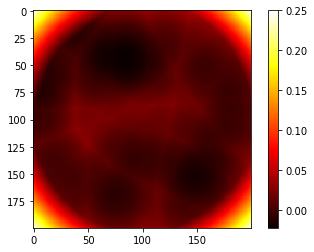

In [16]:
draw_graph(mod)

In [ ]:
mod.save

In [ ]:
# Calculate time for grid method
start = time.time()
for k in range(10):
    loss = torch.zeros(1)
    for i in range(xl):
        for j in range(yl):        
            x_input = np.zeros(m)
            x_input[0] = xs[i, j]
            x_input[1] = ys[i, j]
            if x_input[0] ** 2 + x_input[1] ** 2 < 1:
                x_input = torch.tensor(x_input).float()
                y = model(x_input)
                
                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_grad_1 = (model(x_input_1) - y) / 0.0001
                x_input_grad_2 = (model(x_input_2) - y) / 0.0001

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2) - y
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                
    loss /= (xl * yl)
    
    regularization = torch.zeros(1)
    for t in range(n2):
        theta = t / n2 * (2 * pi)
        x_input = np.zeros(m)
        x_input[0] = cos(theta)
        x_input[1] = sin(theta)
        x_input = torch.tensor(x_input).float()
        y = model(x_input)
        regularization += y**2 
    regularization *= mm / n2
    if mm < 500:
        mm = mm * 1.01
        
    #print loss
    print(k, " epoch, loss: ", loss.data[0].numpy())
    print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
    print(k, " loss to real solution: ", cal_loss())
    if cal_loss() < 0.0001:
        break
    
    loss += regularization
    
    #and step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
stop = time.time()
print(stop - start)

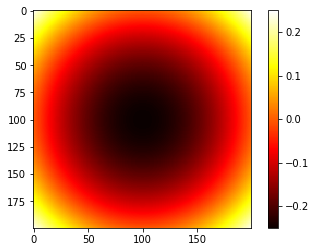

0.098049999999999998

In [35]:
#torch.save(model.state_dict(), '2/model.pkl')
draw_graph()
cal_loss()